# Store Department wise Model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle

In [2]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
data=pd.read_pickle('/notebooks/final_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,lag_21,lag_28,lag_30,lag_45,lag_60,lag_80,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend
6098000,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1501,0,2015-03-09,11506,...,0.0,0.0,2.0,0.0,2.0,0.0,0.646973,0.0,0.669434,-0.669434
6098001,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1501,1,2015-03-09,11506,...,0.0,0.0,0.0,0.0,0.0,1.0,0.318359,1.0,0.304932,0.695312


In [4]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:00<00:00, 47.27it/s]


In [5]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [6]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [7]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.1 MB/s eta 0:00:00


In [8]:
data.drop(['date'],axis=1,inplace=True)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse

In [10]:
!pwd

/notebooks


In [11]:
os.chdir('/notebooks/store Department wise')

In [12]:
from tqdm import tqdm
import joblib
import warnings
warnings.filterwarnings('ignore')
import gc
valid_preds={}
eval_preds={}
data_new = pd.DataFrame()
department=d_dept_id.keys()
stores = d_store_id.keys()
validation = pd.DataFrame()
evaluation = pd.DataFrame()
for store in tqdm(stores):
    for dep in department:
        df = data[(data['store_id']==store) &(data['dept_id']==dep)]
        #Split the data
        X_train, y_train = df[df['d']<1914].drop('demand',axis=1), df[df['d']<1914]['demand']
        X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('demand',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['demand']
        X_test = df[df['d']>=1942].drop('demand',axis=1)

        #Train and validate
        model = LGBMRegressor(objective ='tweedie',
            tweedie_variance_power=1.5,
            n_estimators=1000,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300
        )
        print('*****Prediction for Store: {}, and Department: {}*****'.format(d_store_id[store],d_dept_id[dep]))
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                 eval_metric='rmse', verbose=20, early_stopping_rounds=15)
        y_pred_valid=model.predict(X_valid)
        y_pred_eval=model.predict(X_test)
        X_valid['demand']=y_pred_valid
        X_test['demand']=y_pred_eval
        X_valid=X_valid[['id','d','demand']]
        X_test=X_test[['id','d','demand']]
        validation=validation.append(X_valid)
        evaluation=evaluation.append(X_test)
        filename = 'model_'+str(d_store_id[store])+'_'+str(d_dept_id[dep])+'.pkl'
        # save model
        joblib.dump(model, filename)
        del model, X_train, y_train, X_valid, y_valid
        gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

*****Prediction for Store: CA_1, and Department: HOBBIES_1*****
[20]	training's rmse: 0.148787	training's tweedie: 2.46733	valid_1's rmse: 0.046959	valid_1's tweedie: 2.5249
*****Prediction for Store: CA_1, and Department: HOBBIES_2*****
[20]	training's rmse: 0.278767	training's tweedie: 0.891182	valid_1's rmse: 0.0561637	valid_1's tweedie: 1.01965
*****Prediction for Store: CA_1, and Department: HOUSEHOLD_1*****
[20]	training's rmse: 0.142783	training's tweedie: 3.25834	valid_1's rmse: 0.0391263	valid_1's tweedie: 3.28022
*****Prediction for Store: CA_1, and Department: HOUSEHOLD_2*****
[20]	training's rmse: 0.0333902	training's tweedie: 1.27291	valid_1's rmse: 0.0164998	valid_1's tweedie: 1.42983
*****Prediction for Store: CA_1, and Department: FOODS_1*****
[20]	training's rmse: 0.110324	training's tweedie: 3.1475	valid_1's rmse: 0.53279	valid_1's tweedie: 3.45027
[40]	training's rmse: 0.102397	training's tweedie: 3.14389	valid_1's rmse: 0.52847	valid_1's tweedie: 3.44715
*****Predic

 10%|█         | 1/10 [03:24<30:41, 204.56s/it]

*****Prediction for Store: CA_2, and Department: HOBBIES_1*****
[20]	training's rmse: 0.103792	training's tweedie: 1.90362	valid_1's rmse: 0.0246324	valid_1's tweedie: 2.17665
*****Prediction for Store: CA_2, and Department: HOBBIES_2*****
[20]	training's rmse: 0.178059	training's tweedie: 0.883282	valid_1's rmse: 0.0609868	valid_1's tweedie: 1.08426
*****Prediction for Store: CA_2, and Department: HOUSEHOLD_1*****
[20]	training's rmse: 0.106454	training's tweedie: 3.05284	valid_1's rmse: 0.0680659	valid_1's tweedie: 3.61669
*****Prediction for Store: CA_2, and Department: HOUSEHOLD_2*****
[20]	training's rmse: 0.132607	training's tweedie: 1.59356	valid_1's rmse: 0.018753	valid_1's tweedie: 1.8478
*****Prediction for Store: CA_2, and Department: FOODS_1*****
[20]	training's rmse: 0.178349	training's tweedie: 3.56289	valid_1's rmse: 0.0773072	valid_1's tweedie: 4.56791
*****Prediction for Store: CA_2, and Department: FOODS_2*****
[20]	training's rmse: 0.0572986	training's tweedie: 2.213

 20%|██        | 2/10 [06:00<23:28, 176.08s/it]

*****Prediction for Store: CA_3, and Department: HOBBIES_1*****
[20]	training's rmse: 0.349262	training's tweedie: 2.65116	valid_1's rmse: 0.0928798	valid_1's tweedie: 2.66154
[40]	training's rmse: 0.243423	training's tweedie: 2.64795	valid_1's rmse: 0.0790469	valid_1's tweedie: 2.65842
[60]	training's rmse: 0.195673	training's tweedie: 2.64706	valid_1's rmse: 0.079031	valid_1's tweedie: 2.65757
*****Prediction for Store: CA_3, and Department: HOBBIES_2*****
[20]	training's rmse: 0.168059	training's tweedie: 1.13765	valid_1's rmse: 0.12059	valid_1's tweedie: 1.41374
*****Prediction for Store: CA_3, and Department: HOUSEHOLD_1*****
[20]	training's rmse: 0.0954808	training's tweedie: 4.50277	valid_1's rmse: 0.0525547	valid_1's tweedie: 4.61485
[40]	training's rmse: 0.0883628	training's tweedie: 4.50069	valid_1's rmse: 0.0494026	valid_1's tweedie: 4.61294
[60]	training's rmse: 0.0838752	training's tweedie: 4.49975	valid_1's rmse: 0.0469203	valid_1's tweedie: 4.61206
[80]	training's rmse: 

 30%|███       | 3/10 [15:23<41:09, 352.75s/it]

*****Prediction for Store: CA_4, and Department: HOBBIES_1*****
[20]	training's rmse: 0.127415	training's tweedie: 1.91196	valid_1's rmse: 0.179874	valid_1's tweedie: 2.01878
[40]	training's rmse: 0.119638	training's tweedie: 1.90956	valid_1's rmse: 0.177665	valid_1's tweedie: 2.01647
*****Prediction for Store: CA_4, and Department: HOBBIES_2*****
[20]	training's rmse: 0.0995125	training's tweedie: 0.412246	valid_1's rmse: 0.145691	valid_1's tweedie: 0.498368
*****Prediction for Store: CA_4, and Department: HOUSEHOLD_1*****
[20]	training's rmse: 0.0812194	training's tweedie: 1.9779	valid_1's rmse: 0.259401	valid_1's tweedie: 2.23444
[40]	training's rmse: 0.0791096	training's tweedie: 1.9761	valid_1's rmse: 0.257774	valid_1's tweedie: 2.23279
[60]	training's rmse: 0.076315	training's tweedie: 1.97533	valid_1's rmse: 0.249081	valid_1's tweedie: 2.23204
[80]	training's rmse: 0.0733981	training's tweedie: 1.9751	valid_1's rmse: 0.245966	valid_1's tweedie: 2.23182
[100]	training's rmse: 0.0

 40%|████      | 4/10 [19:51<31:56, 319.37s/it]

*****Prediction for Store: TX_1, and Department: HOBBIES_1*****
[20]	training's rmse: 0.16093	training's tweedie: 1.46882	valid_1's rmse: 0.0598729	valid_1's tweedie: 1.54416
*****Prediction for Store: TX_1, and Department: HOBBIES_2*****
[20]	training's rmse: 0.169887	training's tweedie: 0.725688	valid_1's rmse: 0.0646515	valid_1's tweedie: 0.915832
*****Prediction for Store: TX_1, and Department: HOUSEHOLD_1*****
[20]	training's rmse: 0.0894301	training's tweedie: 3.04145	valid_1's rmse: 0.0373323	valid_1's tweedie: 3.11026
*****Prediction for Store: TX_1, and Department: HOUSEHOLD_2*****
[20]	training's rmse: 0.0946511	training's tweedie: 0.984263	valid_1's rmse: 0.134938	valid_1's tweedie: 1.1531
[40]	training's rmse: 0.0845615	training's tweedie: 0.982513	valid_1's rmse: 0.134044	valid_1's tweedie: 1.15147
*****Prediction for Store: TX_1, and Department: FOODS_1*****
[20]	training's rmse: 0.149855	training's tweedie: 2.25756	valid_1's rmse: 0.0427641	valid_1's tweedie: 2.58172
***

 50%|█████     | 5/10 [23:02<22:43, 272.76s/it]

*****Prediction for Store: TX_2, and Department: HOBBIES_1*****
[20]	training's rmse: 0.092731	training's tweedie: 1.89362	valid_1's rmse: 0.128344	valid_1's tweedie: 2.13888
[40]	training's rmse: 0.076694	training's tweedie: 1.89165	valid_1's rmse: 0.121707	valid_1's tweedie: 2.13709
*****Prediction for Store: TX_2, and Department: HOBBIES_2*****
[20]	training's rmse: 0.20368	training's tweedie: 1.01268	valid_1's rmse: 0.0878173	valid_1's tweedie: 1.16527
*****Prediction for Store: TX_2, and Department: HOUSEHOLD_1*****
[20]	training's rmse: 0.0719747	training's tweedie: 3.16921	valid_1's rmse: 0.0378068	valid_1's tweedie: 3.21443
*****Prediction for Store: TX_2, and Department: HOUSEHOLD_2*****
[20]	training's rmse: 0.0373792	training's tweedie: 1.17574	valid_1's rmse: 0.0249931	valid_1's tweedie: 1.26806
*****Prediction for Store: TX_2, and Department: FOODS_1*****
[20]	training's rmse: 0.120029	training's tweedie: 2.50338	valid_1's rmse: 0.116347	valid_1's tweedie: 2.84447
[40]	tra

 60%|██████    | 6/10 [27:22<17:54, 268.61s/it]

*****Prediction for Store: TX_3, and Department: HOBBIES_1*****
[20]	training's rmse: 0.0854545	training's tweedie: 1.80082	valid_1's rmse: 0.0574321	valid_1's tweedie: 1.98634
[40]	training's rmse: 0.0785509	training's tweedie: 1.79872	valid_1's rmse: 0.052394	valid_1's tweedie: 1.98435
[60]	training's rmse: 0.0741206	training's tweedie: 1.79793	valid_1's rmse: 0.0522504	valid_1's tweedie: 1.98362
*****Prediction for Store: TX_3, and Department: HOBBIES_2*****
[20]	training's rmse: 0.157991	training's tweedie: 0.953126	valid_1's rmse: 0.103269	valid_1's tweedie: 1.21798
[40]	training's rmse: 0.138619	training's tweedie: 0.948691	valid_1's rmse: 0.0926477	valid_1's tweedie: 1.21387
[60]	training's rmse: 0.122976	training's tweedie: 0.946491	valid_1's rmse: 0.0855167	valid_1's tweedie: 1.21196
[80]	training's rmse: 0.111702	training's tweedie: 0.945554	valid_1's rmse: 0.0796253	valid_1's tweedie: 1.21113
[100]	training's rmse: 0.101934	training's tweedie: 0.945052	valid_1's rmse: 0.0733

 70%|███████   | 7/10 [31:41<13:16, 265.57s/it]

*****Prediction for Store: WI_1, and Department: HOBBIES_1*****
[20]	training's rmse: 0.13063	training's tweedie: 2.06326	valid_1's rmse: 0.0475924	valid_1's tweedie: 2.19897
*****Prediction for Store: WI_1, and Department: HOBBIES_2*****
[20]	training's rmse: 0.0941211	training's tweedie: 0.741656	valid_1's rmse: 0.10047	valid_1's tweedie: 0.829827
[40]	training's rmse: 0.0837212	training's tweedie: 0.736427	valid_1's rmse: 0.0965159	valid_1's tweedie: 0.824659
*****Prediction for Store: WI_1, and Department: HOUSEHOLD_1*****
[20]	training's rmse: 0.0506529	training's tweedie: 2.66224	valid_1's rmse: 0.0220267	valid_1's tweedie: 2.78852
*****Prediction for Store: WI_1, and Department: HOUSEHOLD_2*****
[20]	training's rmse: 0.0863836	training's tweedie: 0.985986	valid_1's rmse: 0.0614643	valid_1's tweedie: 1.1157
[40]	training's rmse: 0.0690824	training's tweedie: 0.984378	valid_1's rmse: 0.0613474	valid_1's tweedie: 1.11422
*****Prediction for Store: WI_1, and Department: FOODS_1*****

 80%|████████  | 8/10 [34:31<07:50, 235.16s/it]

*****Prediction for Store: WI_2, and Department: HOBBIES_1*****
[20]	training's rmse: 0.114945	training's tweedie: 1.36777	valid_1's rmse: 0.0855277	valid_1's tweedie: 1.62226
[40]	training's rmse: 0.100744	training's tweedie: 1.36573	valid_1's rmse: 0.083542	valid_1's tweedie: 1.62032
[60]	training's rmse: 0.0908871	training's tweedie: 1.365	valid_1's rmse: 0.0784509	valid_1's tweedie: 1.61966
*****Prediction for Store: WI_2, and Department: HOBBIES_2*****
[20]	training's rmse: 0.238836	training's tweedie: 0.620893	valid_1's rmse: 0.123804	valid_1's tweedie: 0.755182
[40]	training's rmse: 0.21667	training's tweedie: 0.616632	valid_1's rmse: 0.0929294	valid_1's tweedie: 0.750719
[60]	training's rmse: 0.194033	training's tweedie: 0.613852	valid_1's rmse: 0.0810947	valid_1's tweedie: 0.747649
[80]	training's rmse: 0.176738	training's tweedie: 0.612924	valid_1's rmse: 0.0701707	valid_1's tweedie: 0.746731
*****Prediction for Store: WI_2, and Department: HOUSEHOLD_1*****
[20]	training's rm

 90%|█████████ | 9/10 [37:57<03:45, 225.95s/it]

*****Prediction for Store: WI_3, and Department: HOBBIES_1*****
[20]	training's rmse: 0.102532	training's tweedie: 1.38558	valid_1's rmse: 0.0377492	valid_1's tweedie: 1.54392
*****Prediction for Store: WI_3, and Department: HOBBIES_2*****
[20]	training's rmse: 0.11884	training's tweedie: 0.629915	valid_1's rmse: 0.0547976	valid_1's tweedie: 0.800495
*****Prediction for Store: WI_3, and Department: HOUSEHOLD_1*****
[20]	training's rmse: 0.0601452	training's tweedie: 2.56815	valid_1's rmse: 0.0543715	valid_1's tweedie: 2.74733
[40]	training's rmse: 0.0578153	training's tweedie: 2.56616	valid_1's rmse: 0.0519741	valid_1's tweedie: 2.74546
*****Prediction for Store: WI_3, and Department: HOUSEHOLD_2*****
[20]	training's rmse: 0.0657879	training's tweedie: 0.837976	valid_1's rmse: 0.109951	valid_1's tweedie: 0.971941
[40]	training's rmse: 0.0592938	training's tweedie: 0.836467	valid_1's rmse: 0.109096	valid_1's tweedie: 0.970564
*****Prediction for Store: WI_3, and Department: FOODS_1*****

100%|██████████| 10/10 [40:28<00:00, 242.85s/it]


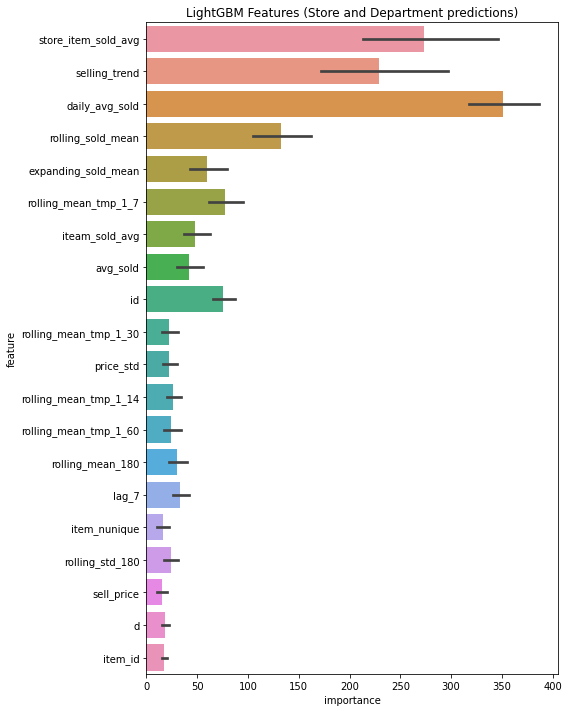

In [13]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'demand']
for filename in os.listdir('/notebooks/store Department wise'):
    if 'model_' in filename:
        # load model
        filename=os.path.join('/notebooks/store Department wise', filename)
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (Store and Department predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

In [14]:
actual = True
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = data[(data['d']>=1914) & (data['d']<=1941)][['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
else:
    #Get the actual validation results
    validation = validation[['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
validation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.989013,0.000012,0.000012,0.000012,0.000012,0.990450,0.999308,0.000012,5.970889,...,1.997276,2.995776,0.995957,0.000012,0.000012,0.000012,0.998621,0.000012,0.000012,0.000013
1,FOODS_1_001_CA_2_validation,0.000083,2.999631,0.000083,0.000083,0.000083,1.001788,3.990039,0.000083,0.000083,...,1.001257,0.000083,0.000083,1.001788,1.001788,0.000083,0.000083,1.001788,1.999666,0.000083
2,FOODS_1_001_CA_3_validation,1.035554,0.000035,0.993032,0.000033,7.978849,1.001440,0.000034,0.000034,1.000826,...,0.997052,1.999838,2.001092,0.000034,0.000034,1.002577,0.000034,2.999751,1.999513,1.999513
3,FOODS_1_001_CA_4_validation,0.000071,0.999843,0.000071,0.000071,0.000071,0.000071,0.999843,0.000071,0.000077,...,0.999843,0.000077,0.000077,0.000077,0.000077,0.999843,0.999843,0.000071,0.000071,0.000071
4,FOODS_1_001_TX_1_validation,0.000074,0.000074,1.000114,0.000074,1.000222,0.000081,1.000222,1.000537,1.000537,...,1.000537,1.000537,1.000537,1.000537,4.972844,0.000081,1.995860,1.995860,0.000081,1.995860


In [15]:
evaluation=evaluation[['id','d','demand']]
evaluation['id']=evaluation['id'].map(d_id)
evaluation = pd.pivot(evaluation, index='id', columns='d', values='demand').reset_index()
evaluation.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,...,0.000013,0.000012,0.000012,0.000012,0.000012,0.000015,0.000015,0.000015,0.000015,0.000015
1,FOODS_1_001_CA_2_evaluation,0.000083,0.000083,0.000083,0.000083,0.000083,0.000102,0.000102,0.000102,0.000102,...,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102
2,FOODS_1_001_CA_3_evaluation,0.000034,0.000034,0.000034,0.000034,0.000034,0.000035,0.000047,0.000053,0.000053,...,0.000051,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049
3,FOODS_1_001_CA_4_evaluation,0.000071,0.000071,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,...,0.000096,0.000096,0.000096,0.000096,0.000096,0.000096,0.000096,0.000096,0.000096,0.000096
4,FOODS_1_001_TX_1_evaluation,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000074,0.000074,0.000074,...,0.000074,0.000074,0.000074,0.000074,0.000074,0.000074,0.000074,0.000074,0.000074,0.000074


In [16]:
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('store_dept_lgbm_submission.csv',index=False)

## Weekly Models

In [17]:
data=pd.read_pickle('/notebooks/final_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,lag_21,lag_28,lag_30,lag_45,lag_60,lag_80,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend
6098000,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1501,0,2015-03-09,11506,...,0.0,0.0,2.0,0.0,2.0,0.0,0.646973,0.0,0.669434,-0.669434
6098001,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1501,1,2015-03-09,11506,...,0.0,0.0,0.0,0.0,0.0,1.0,0.318359,1.0,0.304932,0.695312


In [18]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:00<00:00, 85.18it/s]


In [19]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [20]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [23]:
data.drop(['date'],axis=1,inplace=True)

In [30]:
!pwd

/notebooks/store Department wise/weekly_model


In [29]:
os.chdir('/notebooks/store Department wise/weekly_model')

In [31]:
from tqdm import tqdm
import joblib
import warnings
warnings.filterwarnings('ignore')
import gc
valid_preds={}
eval_preds={}
data_new = pd.DataFrame()
department=d_dept_id.keys()
stores = d_store_id.keys()
validation = pd.DataFrame()
evaluation = pd.DataFrame()
for store in tqdm(stores):
    for cat in department:
        df = data[(data['store_id']==store) &(data['dept_id']==cat)]
        count=0
        for week in range(0,28,7):
            count+=1
            #Split the data
            X_train, y_train = df[df['d']<1914+week].drop('demand',axis=1), df[df['d']<1914+week]['demand']
            X_valid, y_valid = df[(df['d']>=1914+week) & (df['d']<=1920+week)].drop('demand',axis=1), df[(df['d']>=1914+week) & (df['d']<=1920+week)]['demand']
            X_test = df[(df['d']>=1942+week) & (df['d']<=1948+week)].drop('demand',axis=1)

            #Train and validate
            model = LGBMRegressor(objective ='tweedie',
                tweedie_variance_power=1.5,
                n_estimators=1000,
                learning_rate=0.3,
                subsample=0.8,
                colsample_bytree=0.8,
                max_depth=8,
                num_leaves=50,
                min_child_weight=300
            )
            print('*****Prediction for Store: {}, department: {}, and week: {}*****'.format(d_store_id[store],d_dept_id[cat],count))
            model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                     eval_metric='rmse', verbose=20, early_stopping_rounds=20)
            y_pred_valid=model.predict(X_valid)
            y_pred_eval=model.predict(X_test)
            X_valid['demand']=y_pred_valid
            X_test['demand']=y_pred_eval
            X_valid=X_valid[['id','d','demand']]
            X_test=X_test[['id','d','demand']]
            X_valid = pd.pivot(X_valid, index='id', columns='d', values='demand').reset_index()
            X_test = pd.pivot(X_test, index='id', columns='d', values='demand').reset_index()
            validation = pd.concat([validation, X_valid], axis=0)
            evaluation = pd.concat([evaluation, X_test], axis=0)
            filename = 'model_'+str(d_store_id[store])+'_'+str(d_dept_id[cat])+'_week_'+str(count)+'.pkl'
            # save model
            joblib.dump(model, filename)
            del model, X_train, y_train, X_valid, y_valid
            gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

*****Prediction for Store: CA_1, department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.148787	training's tweedie: 2.46733	valid_1's rmse: 0.0401276	valid_1's tweedie: 2.46146
*****Prediction for Store: CA_1, department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.151599	training's tweedie: 2.46721	valid_1's rmse: 0.0649059	valid_1's tweedie: 2.55615
*****Prediction for Store: CA_1, department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.150582	training's tweedie: 2.46866	valid_1's rmse: 0.0481394	valid_1's tweedie: 2.68129
[40]	training's rmse: 0.13869	training's tweedie: 2.46568	valid_1's rmse: 0.0447738	valid_1's tweedie: 2.67848
*****Prediction for Store: CA_1, department: HOBBIES_1, and week: 4*****
[20]	training's rmse: 0.148115	training's tweedie: 2.47209	valid_1's rmse: 0.0343877	valid_1's tweedie: 2.40063
[40]	training's rmse: 0.133347	training's tweedie: 2.46916	valid_1's rmse: 0.0302157	valid_1's tweedie: 2.3977
[60]	training's rmse: 0.126124	trainin

 10%|█         | 1/10 [11:42<1:45:24, 702.77s/it]

*****Prediction for Store: CA_2, department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.103792	training's tweedie: 1.90362	valid_1's rmse: 0.0247372	valid_1's tweedie: 2.12645
[40]	training's rmse: 0.09336	training's tweedie: 1.9016	valid_1's rmse: 0.0199252	valid_1's tweedie: 2.12456
[60]	training's rmse: 0.0851845	training's tweedie: 1.90075	valid_1's rmse: 0.0252268	valid_1's tweedie: 2.12377
*****Prediction for Store: CA_2, department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.0995666	training's tweedie: 1.90731	valid_1's rmse: 0.027091	valid_1's tweedie: 2.14951
[40]	training's rmse: 0.0915944	training's tweedie: 1.90533	valid_1's rmse: 0.0245706	valid_1's tweedie: 2.1476
*****Prediction for Store: CA_2, department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.100333	training's tweedie: 1.91128	valid_1's rmse: 0.0242419	valid_1's tweedie: 2.1353
[40]	training's rmse: 0.0866494	training's tweedie: 1.90922	valid_1's rmse: 0.0260914	valid_1's tweedie: 2.1333

 20%|██        | 2/10 [28:12<1:56:12, 871.56s/it]

*****Prediction for Store: CA_3, department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.349262	training's tweedie: 2.65116	valid_1's rmse: 0.0405325	valid_1's tweedie: 2.6659
*****Prediction for Store: CA_3, department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.344087	training's tweedie: 2.6512	valid_1's rmse: 0.0512604	valid_1's tweedie: 2.69147
[40]	training's rmse: 0.250588	training's tweedie: 2.6484	valid_1's rmse: 0.0520523	valid_1's tweedie: 2.68879
*****Prediction for Store: CA_3, department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.347745	training's tweedie: 2.65185	valid_1's rmse: 0.0337725	valid_1's tweedie: 2.60807
[40]	training's rmse: 0.242182	training's tweedie: 2.64908	valid_1's rmse: 0.0278258	valid_1's tweedie: 2.60532
[60]	training's rmse: 0.194019	training's tweedie: 2.64799	valid_1's rmse: 0.0249219	valid_1's tweedie: 2.60427
[80]	training's rmse: 0.150632	training's tweedie: 2.64766	valid_1's rmse: 0.0255435	valid_1's tweedie: 2.60394


 30%|███       | 3/10 [54:13<2:18:23, 1186.19s/it]

*****Prediction for Store: CA_4, department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.127415	training's tweedie: 1.91196	valid_1's rmse: 0.0285293	valid_1's tweedie: 1.9835
[40]	training's rmse: 0.119638	training's tweedie: 1.90956	valid_1's rmse: 0.0307859	valid_1's tweedie: 1.98115
*****Prediction for Store: CA_4, department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.12707	training's tweedie: 1.91318	valid_1's rmse: 0.0228819	valid_1's tweedie: 2.01186
[40]	training's rmse: 0.11402	training's tweedie: 1.91054	valid_1's rmse: 0.0270235	valid_1's tweedie: 2.00939
*****Prediction for Store: CA_4, department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.128176	training's tweedie: 1.91477	valid_1's rmse: 0.0790193	valid_1's tweedie: 2.04952
*****Prediction for Store: CA_4, department: HOBBIES_1, and week: 4*****
[20]	training's rmse: 0.126802	training's tweedie: 1.91691	valid_1's rmse: 0.34645	valid_1's tweedie: 2.02975
[40]	training's rmse: 0.116314	training's

 40%|████      | 4/10 [1:10:02<1:49:15, 1092.66s/it]

*****Prediction for Store: TX_1, department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.16093	training's tweedie: 1.46882	valid_1's rmse: 0.0751782	valid_1's tweedie: 1.55853
*****Prediction for Store: TX_1, department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.163086	training's tweedie: 1.47032	valid_1's rmse: 0.0271508	valid_1's tweedie: 1.44285
*****Prediction for Store: TX_1, department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.161252	training's tweedie: 1.46985	valid_1's rmse: 0.0631619	valid_1's tweedie: 1.54448
[40]	training's rmse: 0.137242	training's tweedie: 1.46791	valid_1's rmse: 0.0597173	valid_1's tweedie: 1.54259
[60]	training's rmse: 0.12275	training's tweedie: 1.4672	valid_1's rmse: 0.0486679	valid_1's tweedie: 1.54187
[80]	training's rmse: 0.111655	training's tweedie: 1.46695	valid_1's rmse: 0.0433978	valid_1's tweedie: 1.54165
[100]	training's rmse: 0.102872	training's tweedie: 1.46678	valid_1's rmse: 0.0423044	valid_1's tweedie: 1.54149

 50%|█████     | 5/10 [1:11:37<1:01:04, 732.86s/it] 

*****Prediction for Store: TX_2, department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.092731	training's tweedie: 1.89362	valid_1's rmse: 0.234604	valid_1's tweedie: 2.08573
[40]	training's rmse: 0.076694	training's tweedie: 1.89165	valid_1's rmse: 0.219143	valid_1's tweedie: 2.0839
[60]	training's rmse: 0.0698482	training's tweedie: 1.8908	valid_1's rmse: 0.222621	valid_1's tweedie: 2.0831
*****Prediction for Store: TX_2, department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.0953569	training's tweedie: 1.89682	valid_1's rmse: 0.0227009	valid_1's tweedie: 2.08197
*****Prediction for Store: TX_2, department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.092899	training's tweedie: 1.89986	valid_1's rmse: 0.0893072	valid_1's tweedie: 2.13179
*****Prediction for Store: TX_2, department: HOBBIES_1, and week: 4*****
[20]	training's rmse: 0.0902484	training's tweedie: 1.90359	valid_1's rmse: 0.0526056	valid_1's tweedie: 2.25602
*****Prediction for Store: TX_2, depart

 60%|██████    | 6/10 [1:12:48<33:51, 507.91s/it]  

*****Prediction for Store: TX_3, department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.0854545	training's tweedie: 1.80082	valid_1's rmse: 0.0290913	valid_1's tweedie: 2.01839
[40]	training's rmse: 0.0785509	training's tweedie: 1.79872	valid_1's rmse: 0.0277168	valid_1's tweedie: 2.01638
*****Prediction for Store: TX_3, department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.087131	training's tweedie: 1.80455	valid_1's rmse: 0.0430422	valid_1's tweedie: 1.96634
*****Prediction for Store: TX_3, department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.0850181	training's tweedie: 1.8072	valid_1's rmse: 0.0259027	valid_1's tweedie: 1.90414
[40]	training's rmse: 0.0797869	training's tweedie: 1.80508	valid_1's rmse: 0.0255926	valid_1's tweedie: 1.90218
*****Prediction for Store: TX_3, department: HOBBIES_1, and week: 4*****
[20]	training's rmse: 0.0839466	training's tweedie: 1.80876	valid_1's rmse: 0.102651	valid_1's tweedie: 2.05664
[40]	training's rmse: 0.0767635	t

 70%|███████   | 7/10 [1:13:41<17:57, 359.07s/it]

*****Prediction for Store: WI_1, department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.13063	training's tweedie: 2.06326	valid_1's rmse: 0.0515657	valid_1's tweedie: 2.28253
*****Prediction for Store: WI_1, department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.127338	training's tweedie: 2.06692	valid_1's rmse: 0.0369527	valid_1's tweedie: 2.16953
[40]	training's rmse: 0.110943	training's tweedie: 2.06465	valid_1's rmse: 0.0371337	valid_1's tweedie: 2.16738
*****Prediction for Store: WI_1, department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.126634	training's tweedie: 2.06861	valid_1's rmse: 0.049567	valid_1's tweedie: 2.21352
*****Prediction for Store: WI_1, department: HOBBIES_1, and week: 4*****
[20]	training's rmse: 0.127368	training's tweedie: 2.07119	valid_1's rmse: 0.0580322	valid_1's tweedie: 2.13052
*****Prediction for Store: WI_1, department: HOBBIES_2, and week: 1*****
[20]	training's rmse: 0.0941211	training's tweedie: 0.741656	valid_1's rmse: 

 80%|████████  | 8/10 [1:14:29<08:40, 260.23s/it]

*****Prediction for Store: WI_2, department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.114945	training's tweedie: 1.36777	valid_1's rmse: 0.0983383	valid_1's tweedie: 1.64842
[40]	training's rmse: 0.100744	training's tweedie: 1.36573	valid_1's rmse: 0.101748	valid_1's tweedie: 1.64648
*****Prediction for Store: WI_2, department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.112388	training's tweedie: 1.3721	valid_1's rmse: 0.0290043	valid_1's tweedie: 1.5547
*****Prediction for Store: WI_2, department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.110644	training's tweedie: 1.37511	valid_1's rmse: 0.0520482	valid_1's tweedie: 1.63555
*****Prediction for Store: WI_2, department: HOBBIES_1, and week: 4*****
[20]	training's rmse: 0.110028	training's tweedie: 1.3793	valid_1's rmse: 0.135107	valid_1's tweedie: 1.6493
[40]	training's rmse: 0.0967121	training's tweedie: 1.37743	valid_1's rmse: 0.117394	valid_1's tweedie: 1.64756
[60]	training's rmse: 0.08886	training's t

 90%|█████████ | 9/10 [1:15:21<03:15, 195.09s/it]

*****Prediction for Store: WI_3, department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.102532	training's tweedie: 1.38558	valid_1's rmse: 0.0227534	valid_1's tweedie: 1.56374
[40]	training's rmse: 0.0889386	training's tweedie: 1.3836	valid_1's rmse: 0.0228675	valid_1's tweedie: 1.56196
*****Prediction for Store: WI_3, department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.100737	training's tweedie: 1.38854	valid_1's rmse: 0.0566837	valid_1's tweedie: 1.60164
[40]	training's rmse: 0.0846314	training's tweedie: 1.38658	valid_1's rmse: 0.0642559	valid_1's tweedie: 1.59987
*****Prediction for Store: WI_3, department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.098596	training's tweedie: 1.39201	valid_1's rmse: 0.0382415	valid_1's tweedie: 1.49434
*****Prediction for Store: WI_3, department: HOBBIES_1, and week: 4*****
[20]	training's rmse: 0.0990413	training's tweedie: 1.39359	valid_1's rmse: 0.0245804	valid_1's tweedie: 1.51578
[40]	training's rmse: 0.0861468	tr

100%|██████████| 10/10 [1:16:14<00:00, 457.41s/it]


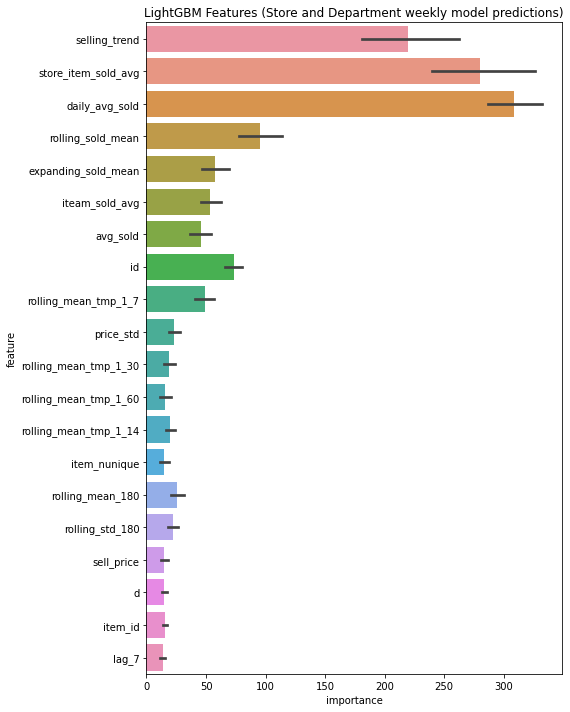

In [33]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'demand']
for filename in os.listdir('/notebooks/store Department wise/weekly_model'):
    if 'model_' in filename:
        # load model
        filename=os.path.join('/notebooks/store Department wise/weekly_model', filename)
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (Store and Department weekly model predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

# Reccursive Models.

In [10]:
data=pd.read_pickle('/notebooks/final_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,lag_21,lag_28,lag_30,lag_45,lag_60,lag_80,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend
6098000,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1501,0,2015-03-09,11506,...,0.0,0.0,2.0,0.0,2.0,0.0,0.646973,0.0,0.669434,-0.669434
6098001,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1501,1,2015-03-09,11506,...,0.0,0.0,0.0,0.0,0.0,1.0,0.318359,1.0,0.304932,0.695312


In [11]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:00<00:00, 53.78it/s]


In [12]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [13]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [14]:
def get_recursion(data):
    lags = [1,2,3,4,5,6,7]
    for lag in lags:
        data["lag_" + str(lag)] = data.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] ,as_index=False)["demand"].shift(lag).astype(np.float16)
    return data

In [15]:
#os.chdir('../.')
os.chdir('/notebooks/store Department wise/Reccursive_model')

In [16]:
data.drop(['date'],axis=1,inplace=True)

In [17]:
!pwd

/notebooks/store Department wise/Reccursive_model


In [18]:
from tqdm import tqdm
import joblib
import warnings
warnings.filterwarnings('ignore')
import gc
valid_preds={}
eval_preds={}
data_new = pd.DataFrame()
department=d_dept_id.keys()
stores = d_store_id.keys()
validation = pd.DataFrame()
evaluation = pd.DataFrame()
for store in tqdm(stores):
    for cat in department:
        df = data[(data['store_id']==store) &(data['dept_id']==cat)]
        count=0
        model = LGBMRegressor(objective ='tweedie',
              tweedie_variance_power=1.5,
              n_estimators=1000,
              learning_rate=0.3,
              subsample=0.8,
              colsample_bytree=0.8,
              max_depth=8,
              num_leaves=50,
              min_child_weight=300
            )
        for week in range(0,28,7):
            print('*****Prediction for Store: {}, Department: {}, and week: {}*****'.format(d_store_id[store],d_dept_id[cat],count))
            count+=1
            df = get_recursion(df)
            X_train, y_train = df[df['d']<1914+week].drop('demand',axis=1), df[df['d']<1914+week]['demand']
            X_valid, y_valid = df[(df['d']>=1914+week) & (df['d']<=1920+week)].drop('demand',axis=1), df[(df['d']>=1914+week) & (df['d']<=1920+week)]['demand']
            X_test = df[(df['d']>=1942+week) & (df['d']<=1948+week)].drop('demand',axis=1)

            #Train and validate
            model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                  eval_metric='rmse', verbose=20, early_stopping_rounds=20)
            y_pred_valid=model.predict(X_valid)
            y_pred_eval=model.predict(X_test)
            X_valid['demand']=y_pred_valid
            X_test['demand']=y_pred_eval
            X_valid=X_valid[['id','d','demand']]
            X_test = X_test[['id','d','demand']]
            validation=validation.append(X_valid)
            evaluation=evaluation.append(X_test)
            data=pd.merge(data, X_valid, on=['id','d'], how='left')
            index = data.index[data['demand_y'].apply(np.isnan)]
            data.loc[index, 'demand_y']=data.loc[index, 'demand_x']
            data.drop('demand_x', axis=1,inplace=True)
            data.rename({'demand_y':'demand'},axis=1, inplace=True)  
            del X_train, y_train, X_valid, y_valid
           
        filename = 'reccursive_model_'+str(d_store_id[store])+'_'+str(d_dept_id[cat])+'_week_'+str(count)+'.pkl'
            # save model
        joblib.dump(model, filename)
        del model
        gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

*****Prediction for Store: CA_1, Department: HOBBIES_1, and week: 0*****
[20]	training's rmse: 0.148786	training's tweedie: 2.46733	valid_1's rmse: 0.0401273	valid_1's tweedie: 2.46146
*****Prediction for Store: CA_1, Department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.152858	training's tweedie: 2.46721	valid_1's rmse: 0.0685229	valid_1's tweedie: 2.55615
*****Prediction for Store: CA_1, Department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.150582	training's tweedie: 2.46866	valid_1's rmse: 0.0481394	valid_1's tweedie: 2.68129
[40]	training's rmse: 0.137178	training's tweedie: 2.46567	valid_1's rmse: 0.0446569	valid_1's tweedie: 2.67841
[60]	training's rmse: 0.124962	training's tweedie: 2.46471	valid_1's rmse: 0.0571832	valid_1's tweedie: 2.67748
*****Prediction for Store: CA_1, Department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.148116	training's tweedie: 2.47209	valid_1's rmse: 0.034382	valid_1's tweedie: 2.40063
[40]	training's rmse: 0.135195	traini

 10%|█         | 1/10 [16:46<2:30:59, 1006.64s/it]

*****Prediction for Store: CA_2, Department: HOBBIES_1, and week: 0*****
[20]	training's rmse: 0.104215	training's tweedie: 1.90362	valid_1's rmse: 0.019203	valid_1's tweedie: 2.12645
[40]	training's rmse: 0.0934859	training's tweedie: 1.90161	valid_1's rmse: 0.0296521	valid_1's tweedie: 2.12457
*****Prediction for Store: CA_2, Department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.0997372	training's tweedie: 1.90731	valid_1's rmse: 0.0234779	valid_1's tweedie: 2.14951
[40]	training's rmse: 0.0880627	training's tweedie: 1.90532	valid_1's rmse: 0.0200109	valid_1's tweedie: 2.14759
*****Prediction for Store: CA_2, Department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.0989211	training's tweedie: 1.91128	valid_1's rmse: 0.0256773	valid_1's tweedie: 2.1353
[40]	training's rmse: 0.0850502	training's tweedie: 1.90922	valid_1's rmse: 0.0293571	valid_1's tweedie: 2.13333
*****Prediction for Store: CA_2, Department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.0976767	t

 20%|██        | 2/10 [33:16<2:12:55, 996.88s/it] 

*****Prediction for Store: CA_3, Department: HOBBIES_1, and week: 0*****
[20]	training's rmse: 0.345323	training's tweedie: 2.65116	valid_1's rmse: 0.0353846	valid_1's tweedie: 2.6659
*****Prediction for Store: CA_3, Department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.343783	training's tweedie: 2.6512	valid_1's rmse: 0.0517992	valid_1's tweedie: 2.69147
[40]	training's rmse: 0.248856	training's tweedie: 2.64841	valid_1's rmse: 0.0472986	valid_1's tweedie: 2.68876
[60]	training's rmse: 0.199185	training's tweedie: 2.64738	valid_1's rmse: 0.049095	valid_1's tweedie: 2.68782
*****Prediction for Store: CA_3, Department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.345838	training's tweedie: 2.65184	valid_1's rmse: 0.0302866	valid_1's tweedie: 2.60806
[40]	training's rmse: 0.242671	training's tweedie: 2.64912	valid_1's rmse: 0.0294701	valid_1's tweedie: 2.60538
*****Prediction for Store: CA_3, Department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.343397	training

 30%|███       | 3/10 [50:56<1:59:39, 1025.62s/it]

*****Prediction for Store: CA_4, Department: HOBBIES_1, and week: 0*****
[20]	training's rmse: 0.127223	training's tweedie: 1.91196	valid_1's rmse: 0.0283617	valid_1's tweedie: 1.9835
[40]	training's rmse: 0.113456	training's tweedie: 1.90943	valid_1's rmse: 0.02574	valid_1's tweedie: 1.98099
[60]	training's rmse: 0.106989	training's tweedie: 1.90864	valid_1's rmse: 0.0261146	valid_1's tweedie: 1.98024
*****Prediction for Store: CA_4, Department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.127177	training's tweedie: 1.91318	valid_1's rmse: 0.0205175	valid_1's tweedie: 2.01186
[40]	training's rmse: 0.114431	training's tweedie: 1.91054	valid_1's rmse: 0.0257439	valid_1's tweedie: 2.00938
*****Prediction for Store: CA_4, Department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.127474	training's tweedie: 1.91477	valid_1's rmse: 0.0854783	valid_1's tweedie: 2.04952
*****Prediction for Store: CA_4, Department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.126744	training

 40%|████      | 4/10 [1:07:09<1:40:29, 1004.93s/it]

*****Prediction for Store: TX_1, Department: HOBBIES_1, and week: 0*****
[20]	training's rmse: 0.160933	training's tweedie: 1.46882	valid_1's rmse: 0.0748331	valid_1's tweedie: 1.55853
*****Prediction for Store: TX_1, Department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.161272	training's tweedie: 1.47032	valid_1's rmse: 0.0271817	valid_1's tweedie: 1.44285
*****Prediction for Store: TX_1, Department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.161323	training's tweedie: 1.46985	valid_1's rmse: 0.0623025	valid_1's tweedie: 1.54448
[40]	training's rmse: 0.141143	training's tweedie: 1.46798	valid_1's rmse: 0.0602424	valid_1's tweedie: 1.54263
[60]	training's rmse: 0.128845	training's tweedie: 1.4672	valid_1's rmse: 0.0693411	valid_1's tweedie: 1.54191
*****Prediction for Store: TX_1, Department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.156759	training's tweedie: 1.47106	valid_1's rmse: 0.0322676	valid_1's tweedie: 1.63071
*****Prediction for Store: TX_1, Depa

 50%|█████     | 5/10 [1:23:19<1:22:41, 992.37s/it] 

*****Prediction for Store: TX_2, Department: HOBBIES_1, and week: 0*****
[20]	training's rmse: 0.0926274	training's tweedie: 1.89362	valid_1's rmse: 0.227836	valid_1's tweedie: 2.08573
[40]	training's rmse: 0.0765099	training's tweedie: 1.8916	valid_1's rmse: 0.217208	valid_1's tweedie: 2.08384
[60]	training's rmse: 0.0681184	training's tweedie: 1.89084	valid_1's rmse: 0.214067	valid_1's tweedie: 2.08311
*****Prediction for Store: TX_2, Department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.0953536	training's tweedie: 1.89682	valid_1's rmse: 0.0215837	valid_1's tweedie: 2.08197
*****Prediction for Store: TX_2, Department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.0928991	training's tweedie: 1.89986	valid_1's rmse: 0.0891549	valid_1's tweedie: 2.13179
*****Prediction for Store: TX_2, Department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.090248	training's tweedie: 1.90359	valid_1's rmse: 0.0525988	valid_1's tweedie: 2.25602
*****Prediction for Store: TX_2, De

 60%|██████    | 6/10 [1:39:40<1:05:53, 988.40s/it]

*****Prediction for Store: TX_3, Department: HOBBIES_1, and week: 0*****
[20]	training's rmse: 0.0862382	training's tweedie: 1.80082	valid_1's rmse: 0.0296687	valid_1's tweedie: 2.01839
[40]	training's rmse: 0.0791142	training's tweedie: 1.79869	valid_1's rmse: 0.0280619	valid_1's tweedie: 2.01634
*****Prediction for Store: TX_3, Department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.087044	training's tweedie: 1.80455	valid_1's rmse: 0.0406245	valid_1's tweedie: 1.96634
*****Prediction for Store: TX_3, Department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.0850258	training's tweedie: 1.80719	valid_1's rmse: 0.0263461	valid_1's tweedie: 1.90415
[40]	training's rmse: 0.0804296	training's tweedie: 1.80506	valid_1's rmse: 0.0241843	valid_1's tweedie: 1.90208
*****Prediction for Store: TX_3, Department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.0844657	training's tweedie: 1.80876	valid_1's rmse: 0.0971073	valid_1's tweedie: 2.05663
[40]	training's rmse: 0.0780776

 70%|███████   | 7/10 [1:55:50<49:07, 982.51s/it]  

*****Prediction for Store: WI_1, Department: HOBBIES_1, and week: 0*****
[20]	training's rmse: 0.132413	training's tweedie: 2.06327	valid_1's rmse: 0.0466089	valid_1's tweedie: 2.28253
*****Prediction for Store: WI_1, Department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.127409	training's tweedie: 2.06692	valid_1's rmse: 0.0376187	valid_1's tweedie: 2.16953
*****Prediction for Store: WI_1, Department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.126633	training's tweedie: 2.06861	valid_1's rmse: 0.0495698	valid_1's tweedie: 2.21352
*****Prediction for Store: WI_1, Department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.127549	training's tweedie: 2.07119	valid_1's rmse: 0.0435942	valid_1's tweedie: 2.13052
*****Prediction for Store: WI_1, Department: HOBBIES_2, and week: 0*****
[20]	training's rmse: 0.0941101	training's tweedie: 0.741658	valid_1's rmse: 0.0408997	valid_1's tweedie: 0.82825
[40]	training's rmse: 0.0834692	training's tweedie: 0.736427	valid_1's rm

 80%|████████  | 8/10 [2:11:51<32:31, 975.52s/it]

*****Prediction for Store: WI_2, Department: HOBBIES_1, and week: 0*****
[20]	training's rmse: 0.114945	training's tweedie: 1.36777	valid_1's rmse: 0.0983381	valid_1's tweedie: 1.64842
[40]	training's rmse: 0.100354	training's tweedie: 1.36578	valid_1's rmse: 0.105175	valid_1's tweedie: 1.64652
*****Prediction for Store: WI_2, Department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.112388	training's tweedie: 1.3721	valid_1's rmse: 0.0290043	valid_1's tweedie: 1.5547
*****Prediction for Store: WI_2, Department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.110876	training's tweedie: 1.37511	valid_1's rmse: 0.0532545	valid_1's tweedie: 1.63555
*****Prediction for Store: WI_2, Department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.110046	training's tweedie: 1.3793	valid_1's rmse: 0.135519	valid_1's tweedie: 1.6493
[40]	training's rmse: 0.096498	training's tweedie: 1.37743	valid_1's rmse: 0.11492	valid_1's tweedie: 1.64756
[60]	training's rmse: 0.0894817	training's t

 90%|█████████ | 9/10 [2:27:51<16:10, 970.70s/it]

*****Prediction for Store: WI_3, Department: HOBBIES_1, and week: 0*****
[20]	training's rmse: 0.102531	training's tweedie: 1.38558	valid_1's rmse: 0.0227291	valid_1's tweedie: 1.56374
[40]	training's rmse: 0.0875819	training's tweedie: 1.3836	valid_1's rmse: 0.0247772	valid_1's tweedie: 1.56196
*****Prediction for Store: WI_3, Department: HOBBIES_1, and week: 1*****
[20]	training's rmse: 0.100737	training's tweedie: 1.38854	valid_1's rmse: 0.0566837	valid_1's tweedie: 1.60164
[40]	training's rmse: 0.0869231	training's tweedie: 1.38658	valid_1's rmse: 0.0631104	valid_1's tweedie: 1.59987
*****Prediction for Store: WI_3, Department: HOBBIES_1, and week: 2*****
[20]	training's rmse: 0.098933	training's tweedie: 1.39201	valid_1's rmse: 0.0362238	valid_1's tweedie: 1.49434
*****Prediction for Store: WI_3, Department: HOBBIES_1, and week: 3*****
[20]	training's rmse: 0.0990348	training's tweedie: 1.39359	valid_1's rmse: 0.0245386	valid_1's tweedie: 1.51578
[40]	training's rmse: 0.0866629	tr

100%|██████████| 10/10 [2:43:44<00:00, 982.46s/it]


In [19]:
actual = True
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = data[(data['d']>=1914) & (data['d']<=1941)][['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
else:
    #Get the actual validation results
    validation = validation[['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
validation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.999455,0.000068,0.000068,0.000068,0.000068,1.000746,1.000746,0.000013,5.983713,...,1.998685,2.995054,1.000672,0.000003,0.000003,0.000003,1.000697,0.000003,0.000003,0.000004
1,FOODS_1_001_CA_2_validation,0.000415,2.990767,0.000415,0.000415,0.000415,1.005453,3.973807,0.000042,0.000042,...,0.996584,0.000020,0.000021,0.991701,0.995718,0.000026,0.000025,0.987627,1.997965,0.000026
2,FOODS_1_001_CA_3_validation,1.001254,0.000079,1.001254,0.000079,7.975775,1.001254,0.000079,0.000192,1.002517,...,0.974849,1.961074,1.998092,0.000065,0.000065,1.005847,0.000065,2.999765,2.000051,2.000051
3,FOODS_1_001_CA_4_validation,0.000071,0.999844,0.000071,0.000071,0.000071,0.000071,0.999844,0.000070,0.000075,...,1.000425,0.000082,0.000082,0.000049,0.000049,0.999957,0.999957,0.000045,0.000045,0.000045
4,FOODS_1_001_TX_1_validation,0.000050,0.000050,1.060450,0.000050,0.999833,0.000055,0.999833,0.999964,0.999964,...,1.000009,1.000009,1.000009,1.000201,4.984251,0.000046,1.997963,1.997963,0.000046,1.997633


In [20]:
evaluation=evaluation[['id','d','demand']]
evaluation['id']=evaluation['id'].map(d_id)
evaluation = pd.pivot(evaluation, index='id', columns='d', values='demand').reset_index()
evaluation.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000019,0.000019,...,0.000090,0.000090,0.000090,0.000004,0.000004,0.000005,0.000004,0.000004,0.000004,0.000004
1,FOODS_1_001_CA_2_evaluation,0.000415,0.000415,0.000415,0.000415,0.000415,0.000471,0.000471,0.000054,0.000054,...,0.000025,0.000025,0.000025,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031
2,FOODS_1_001_CA_3_evaluation,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000115,0.000233,0.000233,...,0.000013,0.000013,0.000013,0.000101,0.000101,0.000101,0.000101,0.000101,0.000101,0.000101
3,FOODS_1_001_CA_4_evaluation,0.000071,0.000071,0.000077,0.000077,0.000077,0.000077,0.000077,0.000075,0.000075,...,0.000082,0.000082,0.000082,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049
4,FOODS_1_001_TX_1_evaluation,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000050,0.000042,0.000042,...,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043


In [21]:
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('store_department_Reccursive_model_lgbm_submission.csv',index=False)

In [10]:
os.chdir('/notebooks/store Department wise/Reccursive_model')

In [11]:
!pwd

/notebooks/store Department wise/Reccursive_model


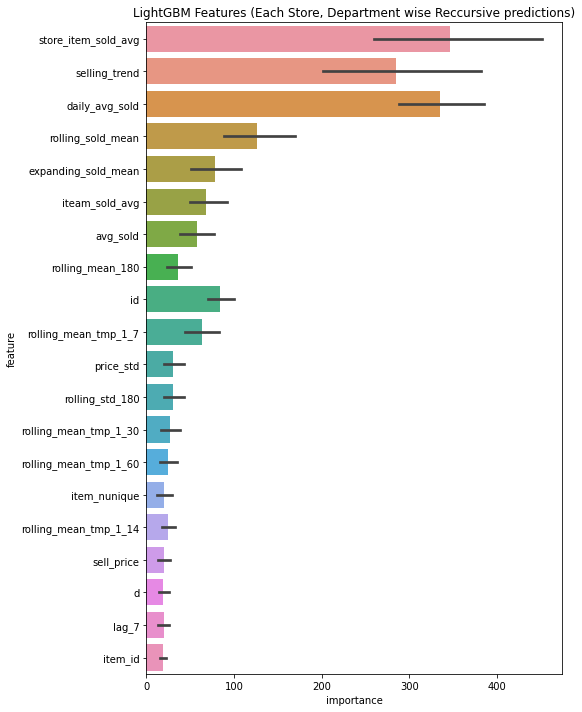

In [14]:
import os
import joblib
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'demand']
for filename in os.listdir('/notebooks/store Department wise/Reccursive_model'):
    if 'reccursive_model' in filename:
        # load model
        filename=os.path.join('/notebooks/store Department wise/Reccursive_model', filename)
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (Each Store, Department wise Reccursive predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)